In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using device: cuda
Epoch 1/25  LossD: 2.3503  LossG: 2.4610
Epoch 2/25  LossD: 0.6873  LossG: 1.6499
Epoch 3/25  LossD: 0.9345  LossG: 0.6987
Epoch 4/25  LossD: 1.1044  LossG: 1.2415
Epoch 5/25  LossD: 1.4332  LossG: 0.9386
Epoch 6/25  LossD: 1.1945  LossG: 1.3900
Epoch 7/25  LossD: 1.7507  LossG: 0.7403
Epoch 8/25  LossD: 1.8260  LossG: 0.6668
Epoch 9/25  LossD: 1.7967  LossG: 1.1504
Epoch 10/25  LossD: 1.6407  LossG: 0.7621
Epoch 11/25  LossD: 1.5228  LossG: 0.3909
Epoch 12/25  LossD: 1.4771  LossG: 0.7756
Epoch 13/25  LossD: 1.5196  LossG: 0.7649
Epoch 14/25  LossD: 1.7970  LossG: 0.5116
Epoch 15/25  LossD: 1.6828  LossG: 0.1442
Epoch 16/25  LossD: 1.4662  LossG: 0.5424
Epoch 17/25  LossD: 1.5101  LossG: 0.3666
Epoch 18/25  LossD: 1.5742  LossG: 0.8016
Epoch 19/25  LossD: 1.6371  LossG: 0.2708
Epoch 20/25  LossD: 1.4459  LossG: 0.9394
Epoch 21/25  LossD: 1.7487  LossG: 0.7054
Epoch 22/25  LossD: 1.7518  LossG: 0.5445
Epoch 23/25  LossD: 1.9254  LossG: 0.0823
Epoch 24/25  LossD: 1.65

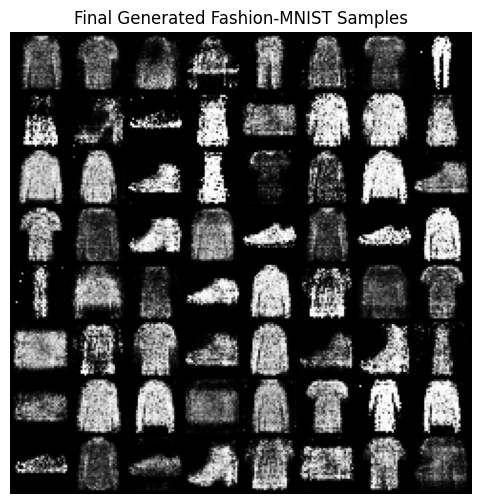

In [11]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# --------------------------
# Hyperbolic ops (Poincaré ball)
# --------------------------

EPS = 1e-6

def project(x, c):
    norm = x.norm(dim=-1, keepdim=True).clamp_min(EPS)
    max_norm = (1 - EPS) / math.sqrt(c)
    scale = torch.clamp(norm, max=max_norm) / norm
    return x * scale

def expmap0(v, c):
    if c == 0:
        return v
    norm = v.norm(dim=-1, keepdim=True).clamp_min(EPS)
    sqrt_c = math.sqrt(c)
    return project(v * torch.tanh(sqrt_c * norm) / (sqrt_c * norm), c)

def logmap0(y, c):
    if c == 0:
        return y
    norm = y.norm(dim=-1, keepdim=True).clamp_min(EPS)
    sqrt_c = math.sqrt(c)
    return y * (torch.atanh(sqrt_c * norm) / (sqrt_c * norm))

# ---------------------------------------------------
# Generator (Euclidean, but INPUT Z is hyperbolic)
# ---------------------------------------------------

class Generator(nn.Module):
    def __init__(self, nz=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(nz, 512), nn.LeakyReLU(0.2),
            nn.Linear(512, 512), nn.LeakyReLU(0.2),
            nn.Linear(512, 1024), nn.LeakyReLU(0.2),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z).view(-1, 1, 28, 28)

# ---------------------------------------------------
# Discriminator (Euclidean)
# ---------------------------------------------------

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28, 512), nn.LeakyReLU(0.2),
            nn.Linear(512, 512), nn.LeakyReLU(0.2),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

# --------------------------
# Hinge Loss
# --------------------------

def D_loss(D_real, D_fake):
    return torch.mean(F.relu(1 - D_real)) + torch.mean(F.relu(1 + D_fake))

def G_loss(D_fake):
    return -torch.mean(D_fake)

# ---------------------------------------------------
# TRAINING
# ---------------------------------------------------

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.FashionMNIST("data", download=True, transform=transform)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

c = 5e-4   # hyperbolic curvature
nz = 128

G = Generator(nz).to(device)
D = Discriminator().to(device)

optG = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
optD = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

fixed_noise = torch.randn(64, nz).to(device)
fixed_noise = expmap0(fixed_noise, c)    # embed in hyperbolic space

epochs = 25

for epoch in range(1, epochs + 1):
    for imgs, _ in loader:
        imgs = imgs.to(device)

        # hyperbolic z
        z = expmap0(torch.randn(imgs.size(0), nz).to(device), c)
        fake = G(z).detach()

        # D step
        D_real = D(imgs)
        D_fake = D(fake)
        lossD = D_loss(D_real, D_fake)

        optD.zero_grad()
        lossD.backward()
        optD.step()

        # G step
        z = expmap0(torch.randn(imgs.size(0), nz).to(device), c)
        fake = G(z)
        lossG = G_loss(D(fake))

        optG.zero_grad()
        lossG.backward()
        optG.step()

    print(f"Epoch {epoch}/{epochs}  LossD: {lossD.item():.4f}  LossG: {lossG.item():.4f}")

# ---------------------------------------------------
# SHOW FINAL IMAGES ONLY
# ---------------------------------------------------

with torch.no_grad():
    samples = G(fixed_noise).cpu()
    samples = (samples + 1) / 2

grid = utils.make_grid(samples, nrow=8)

plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1,2,0))
plt.axis("off")
plt.title("Final Generated Fashion-MNIST Samples")
plt.show()


Device: cuda


100%|██████████| 26.4M/26.4M [00:01<00:00, 17.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 271kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.12MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.4MB/s]


Epoch 1/25  Recon MSE: 0.147399
Epoch 2/25  Recon MSE: 0.119981
Epoch 3/25  Recon MSE: 0.115345
Epoch 4/25  Recon MSE: 0.112710
Epoch 5/25  Recon MSE: 0.110535
Epoch 6/25  Recon MSE: 0.109110
Epoch 7/25  Recon MSE: 0.107696
Epoch 8/25  Recon MSE: 0.106686
Epoch 9/25  Recon MSE: 0.106133
Epoch 10/25  Recon MSE: 0.104742
Epoch 11/25  Recon MSE: 0.104298
Epoch 12/25  Recon MSE: 0.103535
Epoch 13/25  Recon MSE: 0.102778
Epoch 14/25  Recon MSE: 0.102678
Epoch 15/25  Recon MSE: 0.101862
Epoch 16/25  Recon MSE: 0.101412
Epoch 17/25  Recon MSE: 0.100949
Epoch 18/25  Recon MSE: 0.100323
Epoch 19/25  Recon MSE: 0.099890
Epoch 20/25  Recon MSE: 0.099515
Epoch 21/25  Recon MSE: 0.099107
Epoch 22/25  Recon MSE: 0.098918
Epoch 23/25  Recon MSE: 0.098373
Epoch 24/25  Recon MSE: 0.098194
Epoch 25/25  Recon MSE: 0.097782
Originals:


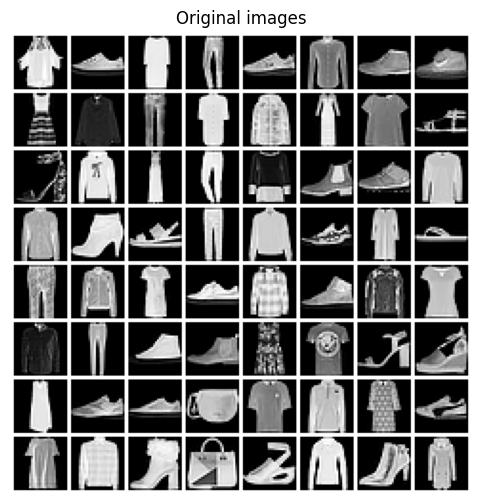

Reconstructions:


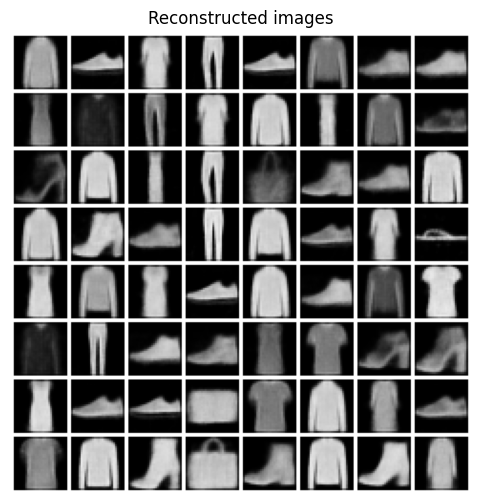

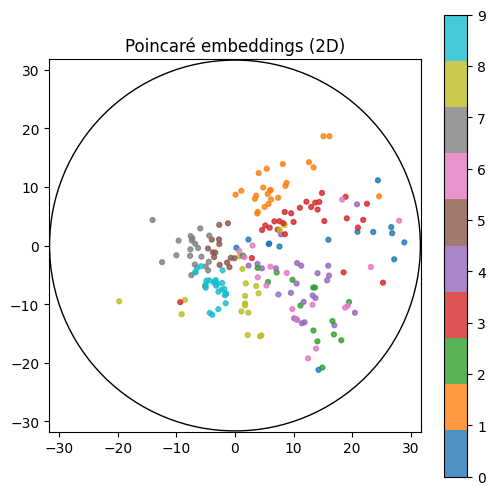

In [1]:
# hyperbolic_autoencoder_fashionmnist.py
# Paste into a Kaggle notebook cell and run. Uses torch, torchvision, matplotlib.

import math, os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# -----------------------
# Poincaré / Hyperbolic ops (no geoopt)
# -----------------------
EPS = 1e-6

def sqnorm(x):
    return (x * x).sum(dim=-1, keepdim=True)

def project(x, c):
    """project points so that c * ||x||^2 < 1 (inside Poincaré ball)"""
    if c <= 0:
        return x
    norm = x.norm(dim=-1, keepdim=True).clamp_min(EPS)
    max_norm = (1 - 1e-5) / math.sqrt(c)
    scale = torch.clamp(norm, max=max_norm) / norm
    return x * scale

def expmap0(v, c):
    """Exponential map at origin: Euclidean -> Poincaré ball"""
    if c == 0:
        return v
    norm = v.norm(dim=-1, keepdim=True).clamp_min(EPS)
    sqrt_c = math.sqrt(c)
    factor = torch.tanh(sqrt_c * norm) / (sqrt_c * norm)
    return project(v * factor, c)

def logmap0(y, c):
    """Log map at origin: Poincaré ball -> Euclidean tangent"""
    if c == 0:
        return y
    norm = y.norm(dim=-1, keepdim=True).clamp_min(EPS)
    sqrt_c = math.sqrt(c)
    factor = torch.atanh(sqrt_c * norm) / (sqrt_c * norm)
    return y * factor

def mobius_matvec(weight, x, c):
    """Möbius matrix-vector multiplication: exp(M * log(x))"""
    # weight: (out, in), x: (batch, in)
    x_t = logmap0(x, c)                 # to tangent
    mx = F.linear(x_t, weight)          # Euclidean matmul
    return expmap0(mx, c)               # back to ball

def mobius_add(u, v, c):
    u2 = sqnorm(u)
    v2 = sqnorm(v)
    uv = (u*v).sum(dim=-1, keepdim=True)
    denom = 1 + 2*c*uv + (c*c)*u2*v2
    num = (1 + 2*c*uv + c*v2)*u + (1 - c*u2)*v
    return project(num / (denom + EPS), c)

# -----------------------
# Optional Hyperbolic Linear Block (used inside latent space)
# -----------------------
class HyperLinear(nn.Module):
    """
    Möbius linear + bias in Poincaré ball:
      out = M ⊗_c x  ⊕_c  b
    where M ⊗ x = exp(M * log(x))
    """
    def __init__(self, in_features, out_features, c=1e-3, bias=True):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_features, in_features) * (1.0 / math.sqrt(in_features)))
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_features))
        else:
            self.bias = None
        self.c = c
        nn.init.xavier_uniform_(self.weight)

    def forward(self, x):
        out = mobius_matvec(self.weight, x, self.c)  # in ball
        if self.bias is not None:
            b = expmap0(self.bias.unsqueeze(0).expand(out.size(0), -1), self.c)
            out = mobius_add(out, b, self.c)
        return project(out, self.c)

def mobius_leaky_relu(x, c, negative_slope=0.2):
    """Apply activation by log -> act -> exp (standard way)"""
    xt = logmap0(x, c)
    at = F.leaky_relu(xt, negative_slope=negative_slope)
    return expmap0(at, c)

# -----------------------
# Autoencoder: Encoder maps image -> Euclidean features -> expmap -> hyperbolic latent
# Decoder: logmap(hyper_latent) -> Euclidean features -> decoder -> image
# -----------------------

class HyperEncoder(nn.Module):
    def __init__(self, latent_dim=2, c=1e-3):
        super().__init__()
        self.c = c
        # simple conv encoder -> Euclidean hidden
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),   # 28->14
            nn.BatchNorm2d(32), nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1),  # 14->7
            nn.BatchNorm2d(64), nn.ReLU(True),
            nn.Flatten()
        )
        self.fc = nn.Linear(64*7*7, 256)
        self.mu = nn.Linear(256, latent_dim)   # Euclidean latent (tangent)
    def forward(self, x):
        h = self.conv(x)
        h = F.relu(self.fc(h))
        z_tangent = self.mu(h)                  # Euclidean tangent coords
        z_hyper = expmap0(z_tangent, self.c)    # map to Poincaré ball => TRUE hyperbolic embedding
        return z_hyper, z_tangent               # return both for convenience

class HyperDecoder(nn.Module):
    def __init__(self, latent_dim=2, c=1e-3):
        super().__init__()
        self.c = c
        # map hyperbolic latent -> tangent -> features -> deconv
        self.fc = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 64*7*7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1), # 7->14
            nn.BatchNorm2d(32), nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 4, 2, 1), # 14->28
            nn.BatchNorm2d(16), nn.ReLU(True),
            nn.Conv2d(16, 1, 3, 1, 1),
            nn.Tanh()
        )
    def forward(self, z_hyper):
        # map to tangent
        z_t = logmap0(z_hyper, self.c)
        h = F.relu(self.fc(z_t))
        h2 = F.relu(self.fc2(h))
        feat = h2.view(-1, 64, 7, 7)
        img = self.decoder(feat)
        return img

# -----------------------
# Full Autoencoder (with optional hyperbolic latent blocks)
# -----------------------
class HyperAutoencoder(nn.Module):
    def __init__(self, latent_dim=2, c=1e-3, use_hyper_blocks=False, hyper_hidden=64):
        super().__init__()
        self.encoder = HyperEncoder(latent_dim=latent_dim, c=c)
        self.use_hyper_blocks = use_hyper_blocks
        self.c = c
        if use_hyper_blocks:
            # operate in hyperbolic latent space with a couple of HyperLinear layers
            self.h1 = HyperLinear(latent_dim, hyper_hidden, c=c)
            self.h2 = HyperLinear(hyper_hidden, latent_dim, c=c)
        self.decoder = HyperDecoder(latent_dim=latent_dim, c=c)

    def forward(self, x):
        z_h, z_t = self.encoder(x)   # z_h is in Poincaré ball
        if self.use_hyper_blocks:
            z_h = self.h1(z_h)
            z_h = mobius_leaky_relu(z_h, self.c)
            z_h = self.h2(z_h)
            z_h = project(z_h, self.c)
        recon = self.decoder(z_h)
        return recon, z_h

# -----------------------
# Training utilities & run
# -----------------------

def show_images_grid(imgs, title=None):
    imgs = imgs.detach().cpu()
    imgs = (imgs + 1.0) / 2.0   # from [-1,1] -> [0,1]
    grid = utils.make_grid(imgs, nrow=8, pad_value=1.0)
    plt.figure(figsize=(6,6))
    plt.imshow(grid.permute(1,2,0).squeeze(), cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

def plot_poincare_points(z_h, labels=None, c=1e-3, title="Poincaré embeddings (2D)"):
    """
    Plot points inside Poincaré disk (assumes latent dim == 2 or input is 2D projection).
    """
    z = z_h.detach().cpu().numpy()
    if z.shape[1] > 2:
        raise ValueError("plot_poincare_points expects 2D latent vectors.")
    x = z[:,0]; y = z[:,1]
    r = 1.0 / math.sqrt(c)
    plt.figure(figsize=(6,6))
    circle = plt.Circle((0,0), r, color='k', fill=False, linewidth=1)
    ax = plt.gca()
    ax.add_patch(circle)
    sc = ax.scatter(x, y, c=labels, cmap='tab10', s=12, alpha=0.8)
    plt.xlim(-r-0.1, r+0.1); plt.ylim(-r-0.1, r+0.1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(title)
    if labels is not None:
        plt.colorbar(sc)
    plt.show()

def train_autoencoder(
    epochs=30,
    batch_size=128,
    latent_dim=16,
    c=1e-3,
    lr=1e-3,
    use_hyper_blocks=False,
    device_str=None,
    show_final=True,
    data_root='data'
):
    device = torch.device(device_str or ("cuda" if torch.cuda.is_available() else "cpu"))
    print("Device:", device)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    ds = datasets.FashionMNIST(data_root, train=True, download=True, transform=transform)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    model = HyperAutoencoder(latent_dim=latent_dim, c=c, use_hyper_blocks=use_hyper_blocks).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    it = 0
    for epoch in range(1, epochs+1):
        running_loss = 0.0
        for imgs, _ in loader:
            imgs = imgs.to(device)
            recon, z_h = model(imgs)
            loss = criterion(recon, imgs)
            opt.zero_grad()
            loss.backward()
            opt.step()
            running_loss += loss.item() * imgs.size(0)
            it += 1
        epoch_loss = running_loss / len(loader.dataset)
        print(f"Epoch {epoch}/{epochs}  Recon MSE: {epoch_loss:.6f}")

    # Display final reconstructions for a fixed batch
    if show_final:
        model.eval()
        with torch.no_grad():
            sample_imgs, sample_labels = next(iter(loader))
            sample_imgs = sample_imgs.to(device)[:64]
            recon, z_h = model(sample_imgs)
            # show original and recon
            print("Originals:")
            show_images_grid(sample_imgs[:64], title="Original images")
            print("Reconstructions:")
            show_images_grid(recon[:64], title="Reconstructed images")
            # show hyperbolic embeddings
            z_all = []
            labels_all = []
            # collect a subset for visualization
            with torch.no_grad():
                for i, (imgs, labs) in enumerate(loader):
                    imgs = imgs.to(device)
                    _, z_h_batch = model(imgs)
                    z_all.append(z_h_batch.cpu())
                    labels_all.append(labs)
                    if i >= 20:   # limit to ~20 batches to visualize
                        break
            z_all = torch.cat(z_all, dim=0)
            labels_all = torch.cat(labels_all, dim=0)
            if latent_dim == 2:
                plot_poincare_points(z_all[:200], labels=labels_all[:200].numpy(), c=c)
            else:
                # project to 2D via PCA then plot in disk scaled
                from sklearn.decomposition import PCA
                pca = PCA(n_components=2)
                z2 = pca.fit_transform(z_all.numpy())
                z2 = z2 - z2.mean(axis=0)
                # scale to fit inside disk radius 1/sqrt(c)
                max_r = np.sqrt((z2**2).sum(axis=1)).max()
                if max_r > 0:
                    z2 = z2 / (1.05*max_r) * (1.0 / math.sqrt(c) * 0.9)
                z2_t = torch.from_numpy(z2)
                plot_poincare_points(z2_t[:200], labels=labels_all[:200].numpy(), c=c,
                                     title="PCA projection of hyperbolic embeddings (plotted in Poincaré disk)")

    return model

# -----------------------
# Run (tweak args as needed)
# -----------------------
if __name__ == "__main__":
    # Recommended: latent_dim=2 for visualization; use 16 for better reconstructions (then PCA will be used)
    model = train_autoencoder(
        epochs=25,
        batch_size=128,
        latent_dim=2,        # set 2 for direct disk visualization, larger for better reconstructions
        c=1e-3,              # curvature (tune: 1e-4..1e-2)
        lr=1e-3,
        use_hyper_blocks=False,   # try True to add hyperbolic FC layers in latent
        show_final=True
    )


In [3]:
torch.save(model.state_dict(), "/kaggle/working/hyperbolic_autoencoder.pth")
